In [2]:
import allel
import seaborn as sns
import zarr
import xarray as xr
import plotly.express as px
import dask.array as da
from collections import Counter
import numpy as np
import json
import hashlib
import numba
import pandas as pd
import bokeh.plotting as bkplt
import bokeh.io as bkio
import bokeh.palettes as bokpalet
import bokeh.models as bkmod
import matplotlib.pyplot as plt

from Bio import SeqIO
from pathlib import Path


In [3]:
# Define metadata and qc bool globally to start
#define useful variables
zarr_base_path = f"/scratch/user/uqtdenni/afar_production_bunya/curation/uq-beebe-001/combined_zarr/{{contig}}.zarr"

# Let's start by converting zarrs for the 5 largest contigs - we can do QC on them...
ref_path = '/scratch/user/uqtdenni/afar_production_bunya/reference/VectorBase-54_AfarautiFAR1_Genome.fasta'
# now let's get a list of the contigs that we are going to call over
contig_lengths = {}
for record in SeqIO.parse(ref_path, "fasta"):
    seq_id = record.id
    seq_length = len(record.seq)
    contig_lengths[seq_id] = seq_length
filtered_contigs = {k: v for k, v in sorted(contig_lengths.items(), key=lambda item: item[1], reverse=True) if v > 100000}

# Because these data are unstaged, we need to faff about a bit more and load the unstaged metadata to exclude extra dud samples
df_samples_dirty = pd.read_csv('/scratch/user/uqtdenni/far_hin_1.x/work/metadata_development_20250702/sample_metadata_interim_seq_qc_pass.txt', index_col = 'derived_sample_id')
# And load the final (cleaned) metadata
df_samples = pd.read_csv('/scratch/user/uqtdenni/far_hin_1.x/work/metadata_development_20250702/sample_metadata_pass_qc.txt', index_col = 'derived_sample_id')

# Mask removing samples we removed before the staging step of QC (that I haven't done yet)
qc_bool = df_samples_dirty.index.isin(df_samples.index)

In [4]:
# Define helper functions

zarr_base_path = f"/scratch/user/uqtdenni/afar_production_bunya/curation/uq-beebe-001/combined_zarr/{{contig}}.zarr"

def hash_params(*args, **kwargs):
    """Helper function to hash analysis parameters."""
    o = {
        'args': args,
        'kwargs': kwargs
    }
    s = json.dumps(o, sort_keys=True).encode()
    h = hashlib.md5(s).hexdigest()
    return h

@numba.njit
def hash_columns(x):
    # Here we want to compute a hash for each column in the
    # input array. However, we assume the input array is in
    # C contiguous order, and therefore we scan the array
    # and perform the computation in this order for more
    # efficient memory access.
    #
    # This function uses the DJBX33A hash function which
    # is much faster than computing Python hashes of
    # bytes, as discovered by Tom White in work on sgkit.
    m = x.shape[0]
    n = x.shape[1]
    out = np.empty(n, dtype=np.int64)
    out[:] = 5381
    for i in range(m):
        for j in range(n):
            v = x[i, j]
            out[j] = out[j] * 33 + v
    return out

# Define helper functions
def load_genotype_array(contig, qc_bool=qc_bool, df_samples=df_samples, sample_query = None, n_snps=None, is_segregating=None):
    # Load gts and remove failed qc samples
    z = zarr.open(zarr_base_path.format(contig=contig))
    
    # Variant-level mask: punctulatus_group_filter_pass
    filter_mask = z[f"{contig}/punctulatus_group_filter_pass"][:]
    
    # Apply combined variant mask
    gt = allel.GenotypeChunkedArray(z[f"{contig}/calldata/GT"])
    gt = gt.compress(qc_bool, axis=1)          # Filter samples by QC
    gt = gt.compress(filter_mask, axis=0)    # Filter variants
    
    # If an additional mask is supplied to subset the data from the finished metadata, apply, else return all samples
    if sample_query is not None:
        bool_query = np.array(df_samples.eval(sample_query))
        gt = gt.compress(bool_query, axis=1)

    if is_segregating is not None:
            is_seg = gt.count_alleles()[:].is_segreating()
            gt = gt.compress(is_seg)

    if n_snps is not None:
            gt = select_random_genotypes_sorted(gt, n_snps)

    return gt

def load_position(contig):
        z = zarr.open(zarr_base_path.format(contig = contig))
        filter_mask = z[f"{contig}/punctulatus_group_filter_pass"][:]
        pos =  np.array((z[f"{contig}/variants/POS"]))
        return pos.compress(filter_mask)
        
def select_random_genotypes_sorted(g, x, replace=False, seed=None):
    """
    Select x random genotypes (rows) from a 2D array, returned in sorted order.

    Parameters:
    - array: allel GenotypeArray, shape (n_genotypes, n_features)
    - x: int, number of genotypes (rows) to select
    - replace: bool, whether sampling is with replacement (default: False)
    - seed: int, random seed for reproducibility (default: None)

    Returns:
    - np.ndarray of shape (x, n_features)
    """

    # Select random sites from that set
    rng = np.random.default_rng(seed)
    n_rows = gf.shape[0]
    if not replace and x > n_rows:
        raise ValueError(f"Cannot select {x} rows without replacement from {n_rows} total rows.")
    indices = rng.choice(n_rows, size=x, replace=replace)
    sorted_indices = np.sort(indices)

    return gf[sorted_indices]

def diplotype_frequencies(gt):
    """Compute diplotype frequencies, returning a dictionary that maps
    diplotype hash values to frequencies."""

    # Here are some optimisations to speed up the computation
    # of diplotype hashes. First we combine the two int8 alleles
    # in each genotype call into a single int16.
    m = gt.shape[0]
    n = gt.shape[1]
    x = np.asarray(gt).view(np.int16).reshape((m, n))

    # Now call optimised hashing function.
    hashes = hash_columns(x)

    # Now compute counts and frequencies of distinct haplotypes.
    counts = Counter(hashes)
    freqs = {key: count / n for key, count in counts.items()}

    return freqs
    
def garud_g123(gt):
    """Compute Garud's G123."""

    # compute diplotype frequencies
    frq_counter = diplotype_frequencies(gt)

    # convert to array of sorted frequencies
    f = np.sort(np.fromiter(frq_counter.values(), dtype=float))[::-1]

    # compute G123
    g123 = np.sum(f[:3]) ** 2 + np.sum(f[3:] ** 2)

    return g123

def g123_gwss(contig, window_size, sample_query=None):
    
    z = zarr.open(zarr_base_path.format(contig = contig))

    gt = load_genotype_array(contig, qc_bool=qc_bool, df_samples=df_samples, sample_query = sample_query)

    pos = load_position(contig)

    g123 = allel.moving_statistic(gt, statistic=garud_g123, size=window_size)
    x = allel.moving_statistic(pos, statistic=np.mean, size=window_size)

    return(x, g123)
    
def g123_analysis(contig, window_size, sample_query, results_dir='results_g123_v1'):
    
    params = dict(
            contig=contig,
            window_size=window_size,
            sample_query=sample_query,
        )

     # construct a key to save the results under
    results_key = hash_params(
        params
    )

    # define paths for results files
    g123_path = f'{results_dir}/{results_key}-g123.npy'
    x_path = f'{results_dir}/{results_key}-x.npy'

    try:
        # try to load previously generated results
        g123 = np.load(g123_path)
        x = np.load(x_path)
        return (g123, x)
    except FileNotFoundError:
        # no previous results available, need to run analysis
        print(f'running analysis: {results_key}')
    
    print('setting up inputs')

    results = g123_gwss(**params)

    x = results[0]
    g123 = results[1]

    np.save(g123_path, g123)
    np.save(x_path, x)
    print(f'saved results: {results_key}')

    return (g123, x)


def plot_g123(query,
              winsize,
              title
             ):

    df_contigs = []

    # Progress bar for contigs
    for contig in filtered_contigs.keys():
        
        g,p = g123_analysis(contig, winsize, sample_query=query)
        
        scan_df = pd.DataFrame({'contig':contig,'pos' : p, 'g123':g})

        df_contigs.append(scan_df)

    # Concatenate df and save out
    df = pd.concat(df_contigs)

    # Sort contigs by length (longest first)
    contig_lengths = df.groupby('contig')['pos'].max()
    sorted_contigs = contig_lengths.sort_values(ascending=False).index.tolist()
    sorted_lengths = contig_lengths.loc[sorted_contigs]
    contig_offsets = sorted_lengths.cumsum().shift(fill_value=0)

    df['contig'] = pd.Categorical(df['contig'], categories=sorted_contigs, ordered=True)
    df = df.sort_values(['contig', 'pos']).copy()
    df['contig_offset'] = df['contig'].map(contig_offsets).astype(float)
    df['genome_position'] = df['pos'] + df['contig_offset']

    color_map = {
        contig: ('lightblue' if i % 2 == 0 else 'steelblue')
        for i, contig in enumerate(sorted_contigs)
    }
    df['color'] = df['contig'].map(color_map)

    fig = px.line(
        df,
        x='genome_position',
        y='g123',
        color='contig',
        color_discrete_map=color_map,
        labels={'genome_position': 'Genomic Position', 'g123': 'G123'},
        template = 'simple_white',
        hover_data = ['pos'],
        title=title
    )

    fig.update_traces(marker=dict(size=3))  
    fig.update_layout(showlegend=False)

    
    fig.show()


running analysis: 5fb2cf75b7cd45bb88ab3fea20554cac
setting up inputs
saved results: 5fb2cf75b7cd45bb88ab3fea20554cac
running analysis: dd93b676fb5307ccca49c20580837aa3
setting up inputs
saved results: dd93b676fb5307ccca49c20580837aa3
running analysis: ccbc9e222e15b46d9e0ade4c55327dce
setting up inputs
saved results: ccbc9e222e15b46d9e0ade4c55327dce
running analysis: 9f6f73c5be43d90b90c70079f9335b8b
setting up inputs
saved results: 9f6f73c5be43d90b90c70079f9335b8b
running analysis: a1065b0b4b8f357115f2bc144f9a61ad
setting up inputs
saved results: a1065b0b4b8f357115f2bc144f9a61ad
running analysis: 4c7d059910640db7082051fecd349b79
setting up inputs
saved results: 4c7d059910640db7082051fecd349b79
running analysis: ca9b3a7f90c55827f5292f801a2ccb9f
setting up inputs
saved results: ca9b3a7f90c55827f5292f801a2ccb9f
running analysis: 85e8e33a1f70105726bbf3ed90475077
setting up inputs
saved results: 85e8e33a1f70105726bbf3ed90475077
running analysis: 68a851e73ed9c115d5c4a08c4d18d1fb
setting up in

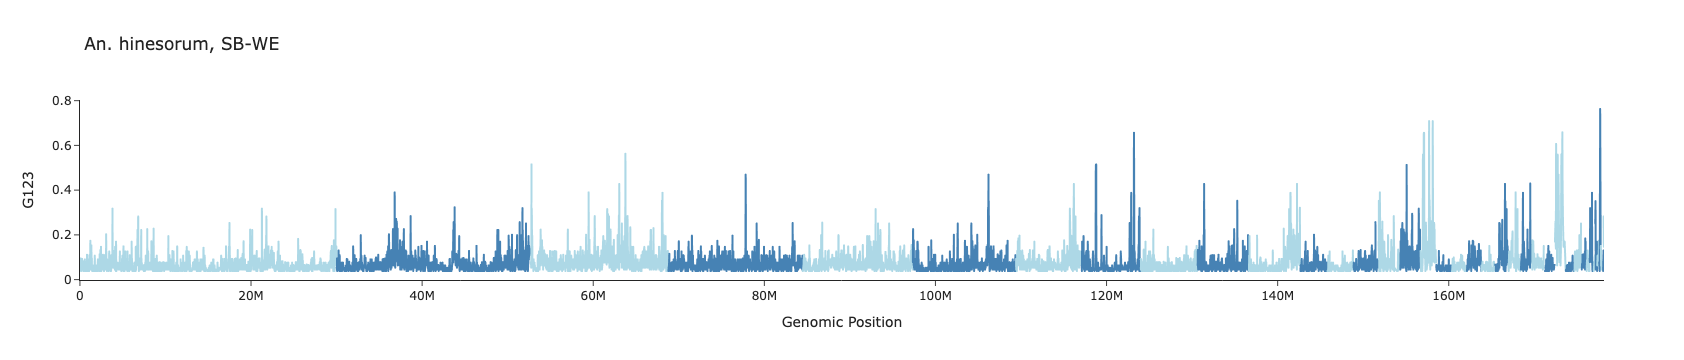

In [5]:
plot_g123(query = 'species_pca == "hinesorum" & admin1_iso == "SB-WE"',
         winsize=3000,
         title = 'An. hinesorum, SB-WE')

In [7]:
plot_g123(query = 'species_pca == "hinesorum" & country_iso == "SB"',
         winsize=5000,
         title = 'An. hinesorum, SB')

In [ ]:
plot_g123(query = 'species_pca == "hinesorum" & country_iso == "SB"',
         winsize=5000,
         title = 'An. hinesorum, SB')